# Usage instructions

The `icenumerics` package is a collection of classes and routines intended to facilitate the simulations of the [colloidal ice](https://doi.org/10.1038/ncomms10575). The actual simulation is done by [LAMMPS](http://lammps.sandia.gov), using a Brownian dynamics addon found in [Lammps_brownian](https://github.com/anyuzx/Lammps_brownian), as well as some custom modifications. For the complete lammps source, please check [here](https://github.com/aortiza/lammps).

This package works by defining a colloidal ice system, creating LAMMPS input scripts, running them through a `os.system` command, and then reading the result from the `.lammpstrj` file. One advantage of this approach is that the output files can be read at a later time even after the workspace has been reset.

Please note that this program is in an early stage of development and it should not be expected to do many more things than what are shown here. However, if you have a suggestion for further functionality, you can raise an [issue](https://github.com/aortiza/icenumerics/issues). And if you want to contribute, you can fork your copy of the package, and then do a pull request. 

## Importing the package

The package is easily imported by writing;
    
    import icenumerics as ice

In [2]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../')

import icenumerics as ice

import matplotlib.pyplot as plt
%matplotlib inline

### Importing the unit registry
One caveat of using `pint` for unit management is that units from one registry can't operate with the units from another one. Therefore, the quantities defined in this script can only operate with quantities defined inside the `icenumerics` module, if we use the unit registry of the module. We can import it by writing:

In [3]:
ureg = ice.ureg

## The Spin Ice object

The first step towards a simulation is to construct a spin ice object. The spin ice will work as a template for the geometry of the colloidal ice later. 

To construct a spin ice object, we can write:

In [4]:
sp = ice.spins()
sp.create_lattice("square",[10,10],lattice_constant=30*ureg.um)

Next we can call the display function to see the graphic representation of the Spin Ice Object. The argument of the function is the axis object in which the figure will be plotted

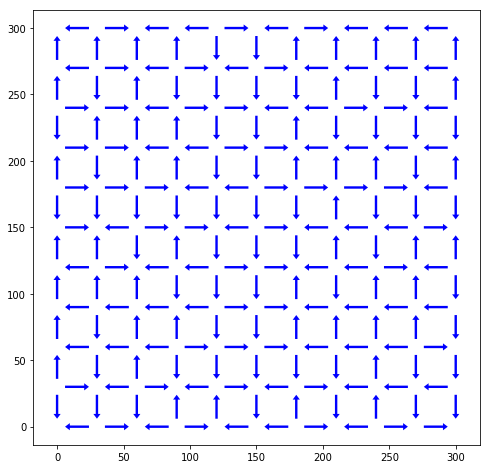

In [5]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
sp.display(ax2)

## The Colloidal Ice object

From the spins object, we can construct a `colloidal_ice`  object. To do this, we need to define some initial parameters for the particles and traps. These two objects will be copied to each spin in the spin ice object.

In [6]:
particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(30*ureg.um)

As before, the display function allows us to visualize the object.

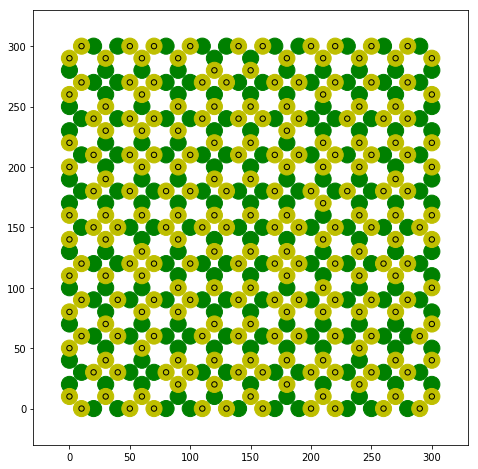

In [7]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)

## Running a simulation

Before running a simulation, we need to create a set of world parameters. This contains things like the field to be applied and the temperature.

In [8]:
world = ice.world(
    field = 10*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

To run the simulation, we use the method `simulate`. If you look at the terminal in which this notebook is running, you should see a LAMMPS output. This is the indicator that everything went well.

In [9]:
col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = r"C:\Users\aortiza\Desktop",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 60*ureg.s,
             output = ["x","y","z"])

When the simulation is finished, it automatically reads the output file and updates the system to it's last position. Therefore, we can see the result by simply displaying again the `colloidal_ice` object

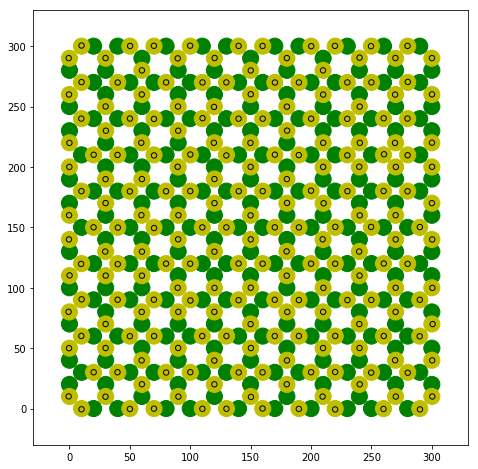

In [10]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)

To access the system state at a different time in the simulation, we can use the method `set_state_from_frame(frame)`. 

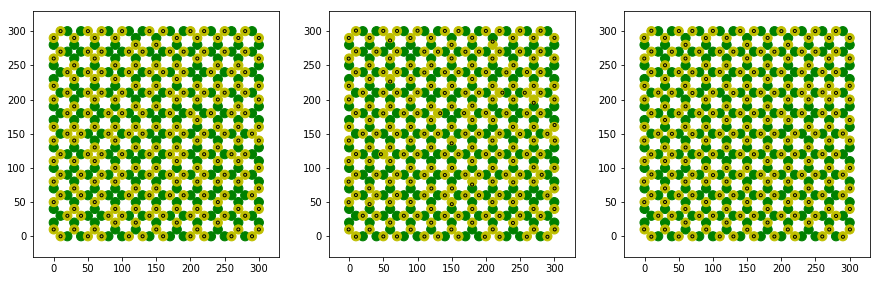

In [11]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,8))
col.set_state_from_frame(0)
col.display(ax1)
col.set_state_from_frame(3)
col.display(ax2)
col.set_state_from_frame(60)
col.display(ax3)

## Simulation trajectories

We can access the full trajectories of the particles, which are stored as a multiindex `pandas` array in the `trj` attribute. To access it, we can simply write 
    
    col.trj
    
Below we use the method `head()`, which prints only the first few rows of a pandas array. This is useful to visualize the structure of an array. 

In [12]:
col.trj.head()

type    x      y    z    t
frame id                            
0     1      1  0.0   10.0  0.1  0.0
      2      1  0.0   50.0  0.1  0.0
      3      1  0.0   80.0  0.1  0.0
      4      1  0.0  110.0  0.1  0.0
      5      1  0.0  140.0  0.1  0.0

## Counting vertices
Often we are interested in the vertex statistics of the colloidal ice system. The package provides some counting methods bundled in the `vertices` object.

In [13]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

We can display both objects on the same axis to see where specific vertex types are located. Vertex types are defined by their charge, and when they have neutral charge, by the sum of their elements. 

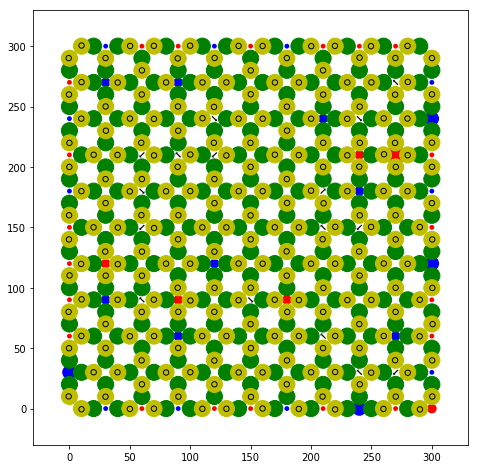

In [14]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

Note here that the vertices are counted from the system state. If we want the vertices at different moments in time, we have to reset the system state to that frame.

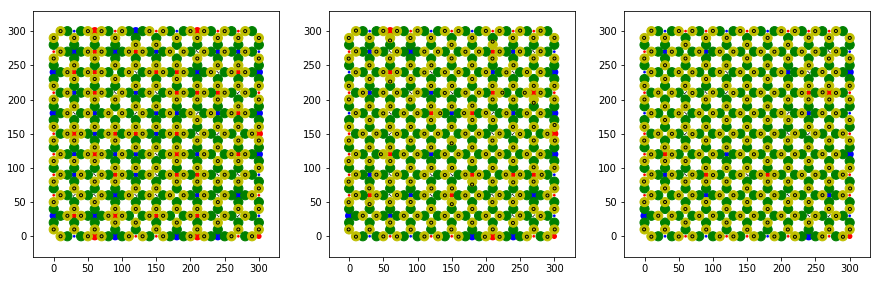

In [15]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,8))

col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)

v.display(ax1)
col.display(ax1)

col.set_state_from_frame(3)
v = v.colloids_to_vertices(col)

v.display(ax2)
col.display(ax2)

col.set_state_from_frame(60)
v = v.colloids_to_vertices(col)

v.display(ax3)
col.display(ax3)

##  Animating a trajectory
The colloidal_ice object has an animate function. This function is based on matplotlib's [FuncAnimation](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html), and thus works similar. To use it, you first define an animation object:

In [16]:
anim = col.animate(sl=slice(0,-1,2),speed=10)

This should be relatively fast, because the animation oject only defines the initialization and update function. The actual drawing is done when the animation object is used. 

To display the animation on a notebook you can write:

In [18]:
from IPython.display import HTML
HTML(anim.to_html5_video())

This normally takes some time, depending on the number of frames being animated. 

If you want to export the video, you can eihter drag it from your browser, or you can write:

In [19]:
anim.save("colloidal_ice_amazing_video.gif",writer = "imagemagick")

This last command requires [imagemagick](https://www.imagemagick.org/script/index.php) to be installed.

## Honeycomb Spin Ice

We will try the exact same procedure with a Honeycomb configuration to ensure everything works

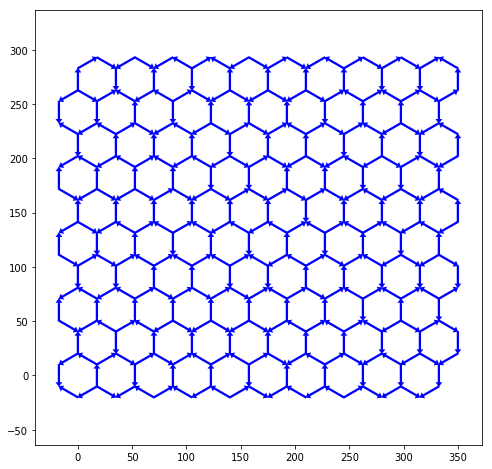

In [22]:
sp = ice.spins()
sp.create_lattice("honeycomb",[10,10],lattice_constant=35*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
sp.display(ax1)

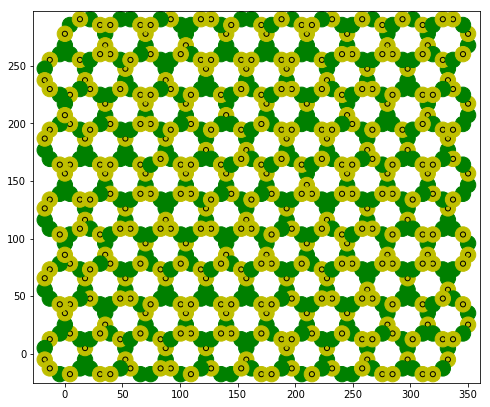

In [23]:
particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)
 
trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(10*ureg.um)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
col.display(ax1)

In [24]:
world = ice.world(
    field = 10*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 20*ureg.um)

col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = r"C:\Users\aortiza\Desktop",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 60*ureg.s,
             output = ["x","y","z"])

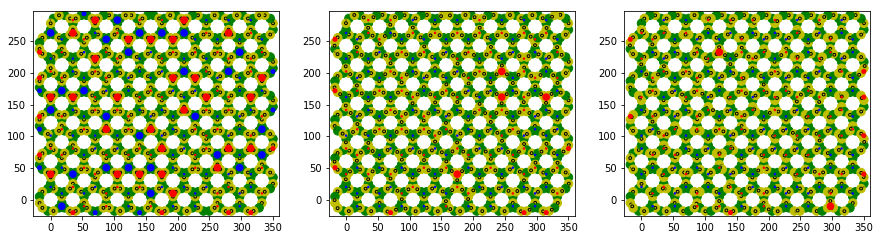

In [25]:
v = ice.vertices()
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,8))

col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)

col.set_state_from_frame(3)
v = v.colloids_to_vertices(col)

col.display(ax2)
v.display(ax2)

col.set_state_from_frame(60)
v = v.colloids_to_vertices(col)

col.display(ax3)
v.display(ax3)